## Яндекс Практикум, курс "Инженер Машинного Обучения" (2024 г.)
## Проект 4-го спринта: "Создание рекомендательной системы"
## Ноутбук для предобработки данных и EDA
***

### Этап 1. Первичная подготовка данных

__Постановка задачи__

Прочитайте файлы с данными, проведите оценку данных на наличие проблем:
- Нужно ли изменить тип идентификаторов?
- Есть ли треки с неизвестными исполнителями, альбомами, жанрами?

При необходимости решите найденные проблемы.

Сохраните предобработанные данные в удобном формате в двух файлах:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

__Исходные данные__

Данные находятся в трёх файлах:

1. Данные о треках — в файле `tracks.parquet`:
    - `track_id` — идентификатор музыкального трека,
    - `albums` — список идентификаторов альбомов, содержащих трек,
    - `artists` — список идентификаторов исполнителей трека,
    - `genres` — список идентификаторов жанров, к которым принадлежит трек.

2. Имена артистов, названия альбомов, треков и жанров — в файле `catalog_names.parquet`:
    - `id` — идентификатор одной из каталожных единиц (трека, альбома, исполнителя, жанра),
    - `type` — тип идентификатора,
    - `name` — имя (название) каталожной единицы.

3. Данные о том, какие пользователи прослушали тот или иной трек — в файле `interactions.parquet`:
    - `user_id` — идентификатор пользователя,
    - `track_id` — идентификатор музыкального трека,
    - `track_seq` — номер места трека в истории пользователя,
    - `started_at` — дата начала прослушивания трека.

In [1]:
import logging
import os
import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_theme(style="whitegrid")

In [2]:
# Проверяем, в каком окружении мы сейчас работаем
print(sys.executable)

c:\Users\Kirill_Nosov\_Repos\.venv\Scripts\python.exe


In [3]:
# Отключаем предупреждения
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

__Загружаем файлы на локальный диск__

In [6]:
# Устанавливаем утилиту wget, если ее нет
!pip install wget

  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for wget, since package 'wheel' is not installed.
  Running setup.py install for wget ... done


In [5]:
!python -m wget -o tracks.parquet https://storage.yandexcloud.net/mle-data/ym/tracks.parquet
!python -m wget -o catalog_names.parquet https://storage.yandexcloud.net/mle-data/ym/catalog_names.parquet
!python -m wget -o interactions.parquet https://storage.yandexcloud.net/mle-data/ym/interactions.parquet


Saved under tracks.parquet

Saved under catalog_names.parquet

Saved under interactions.parquet


__Загружаем и проверяем данные из файла `tracks.parquet`__

In [6]:
tracks = pd.read_parquet("tracks.parquet")
tracks.head()

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


In [7]:
# Смотрим типы колонок, кол-во строк, объем данных и наличие пропусков
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


Пропусков нет, типы корректны. Проверим `track_id` на наличие дубликатов и отрицательных значений.

In [8]:
# Проверяем track_id на наличие дубликатов 
print(f"Все track_id уникальны: {tracks['track_id'].nunique() == len(tracks)}")

# Проверяем track_id на наличие отрицательных значений
print(f"Кол-во отрицательных track_id: {(tracks['track_id'] < 0).sum()}")

Все track_id уникальны: True
Кол-во отрицательных track_id: 0


Таким образом, повторяющихся и отрицательных track_id нет. 

После скачивания данных о каталогах нужно будет также проверить, нет ли в таблице треков идентификаторов альбомов, артистов и жанров, которые указывают на несуществующие каталожные единицы. В дальнейшем такие id будем игнорировать, для чего заменим их, например, на -1.

Что касается треков, у которых одновременно неопределены все три категории альбом/артист/жанр
либо неизвестно название самого трека, то мы не будем их удалять, т.к. они все равно могут оказаться популярными в истории взаимодействий и мы сможем их рекомендавать, например, "холодным" пользователям.

__Загружаем и проверяем данные из файла `catalog_names.parquet`__

In [9]:
catalog_names = pd.read_parquet("catalog_names.parquet")
catalog_names.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [10]:
# Смотрим типы колонок, кол-во строк и объем данных
catalog_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


In [11]:
# Проверяем наличие пропусков
catalog_names.isnull().sum()

id      0
type    0
name    0
dtype: int64

Видим, что пропусков нет, типы колонок корректны. Сделаем еще несколько проверок

In [12]:
# Проверяем id на наличие повторяющихся значений
print(f"Кол-во уникальных id: {catalog_names['id'].nunique()}, общее кол-во строк: {len(catalog_names)}")

# Проверяем id на наличие отрицательных значений
print(f"Кол-во отрицательных id: {(catalog_names['id'] < 0).sum()}")

# Проверяем наличие полностью повторяющихся строк
duplicated_rows_condition = catalog_names.duplicated(catalog_names.columns, keep=False)
print(f"Кол-во полностью повторяющихся строк: {duplicated_rows_condition.sum()}")

Кол-во уникальных id: 1776697, общее кол-во строк: 1812471
Кол-во отрицательных id: 0
Кол-во полностью повторяющихся строк: 0


Отрицательных id и полностью повторяющихся строк нет, но есть повторяющиеся идентификаторы. 
Поскольку таких значений много, то это может быть связано не со случайными ошибками,
а с отдельной нумерацией внутри каждого типа. Убедимся в этом.

In [13]:
# Смотрим, какие есть каталожные типы
catalog_names['type'].unique()

array(['album', 'artist', 'genre', 'track'], dtype=object)

In [14]:
# Проверяем наличие повторяющихся id внутри типа album
cat_albums = catalog_names.query("type == 'album'")
print(f"Среди id альбомов нет повторяющихся: {cat_albums['id'].nunique() == len(cat_albums)}")

# Проверяем наличие повторяющихся id внутри типа artist
cat_artists = catalog_names.query("type == 'artist'")
print(f"Среди id артистов нет повторяющихся: {cat_artists['id'].nunique() == len(cat_artists)}")

# Проверяем наличие повторяющихся id внутри типа genre
cat_genres = catalog_names.query("type == 'genre'")
print(f"Среди id жанров нет повторяющихся: {cat_genres['id'].nunique() == len(cat_genres)}")

# Проверяем наличие повторяющихся id внутри типа track
cat_tracks = catalog_names.query("type == 'track'")
print(f"Среди id названий треков нет повторяющихся: {cat_tracks['id'].nunique() == len(cat_tracks)}")

Среди id альбомов нет повторяющихся: True
Среди id артистов нет повторяющихся: True
Среди id жанров нет повторяющихся: True
Среди id названий треков нет повторяющихся: True


Видим, что кол-во уникальных id внутри каждого типа совпадает с общим кол-вом соответствующих каталожных единиц, значит повторяющихся id среди элементов одного типа действительно нет.

Далее находим в таблице треков идентификаторы альбомов, артистов и жанров, которые указывают на несуществующие каталожные единицы.

In [18]:
# Разворачиваем tracks по каталожным ids и переименовываем соответствующие колонки

tracks_exploded = tracks.explode('albums', ignore_index=True) \
    .explode('artists', ignore_index=True) \
        .explode('genres', ignore_index=True) \
            .rename(columns={'albums':'album_id', 'artists': 'artist_id', 'genres': 'genre_id'})

In [19]:
# Заменяем пропуски в id артистов, жанров и альбомов на -1, т.к.
# a) после такого заполнения мы сможем поменять тип object на int, 
# b) отрицательное число не совпадает ни с одним из id в таблице каталогов.

tracks_exploded['album_id'].fillna(-1, inplace=True)
tracks_exploded['artist_id'].fillna(-1, inplace=True)
tracks_exploded['genre_id'].fillna(-1, inplace=True)

In [20]:
# Меняем тип object на int
tracks_exploded[['album_id', 'artist_id', 'genre_id']] = \
    tracks_exploded[['album_id', 'artist_id', 'genre_id']].astype('int')

In [21]:
# Вставляем в tracks_exploded данные об альбомах
tracks_exploded = tracks_exploded \
    .merge(cat_albums[['id', 'name']], how='left', left_on='album_id', right_on='id') \
        .rename(columns={'name': 'album_name'}).drop(columns='id')

In [22]:
# Вставляем в tracks_exploded данные об артистах
tracks_exploded = tracks_exploded \
    .merge(cat_artists[['id', 'name']], how='left', left_on='artist_id', right_on='id') \
        .rename(columns={'name': 'artist_name'}).drop(columns='id')

In [23]:
# Вставляем в tracks_exploded данные о жанрах
tracks_exploded = tracks_exploded\
    .merge(cat_genres[['id', 'name']], how='left', left_on='genre_id', right_on='id')\
        .rename(columns={'name': 'genre_name'}).drop(columns='id')

In [24]:
# Проверяем кол-во неправильных ссылок на альбомы
wrong_album_ids_condition = (tracks_exploded['album_name'].isnull()) & (tracks_exploded['album_id'] != -1)
print(f"Кол-во неправильных album_id в треках: {wrong_album_ids_condition.sum()}")

# Проверяем кол-во неправильных ссылок на артистов
wrong_artist_ids_condition = (tracks_exploded['artist_name'].isnull()) & (tracks_exploded['artist_id'] != -1)
print(f"Кол-во неправильных artist_id в треках: {wrong_artist_ids_condition.sum()}")

# Проверяем кол-во неправильных ссылок на жанры
wrong_genre_ids_condition = (tracks_exploded['genre_name'].isnull()) & (tracks_exploded['genre_id'] != -1)
print(f"Кол-во неправильных genre_id в треках: {wrong_genre_ids_condition.sum()}")

Кол-во неправильных album_id в треках: 0
Кол-во неправильных artist_id в треках: 0
Кол-во неправильных genre_id в треках: 193604


Видим, что в треках есть ссылки на несуществующие жанры. Заменим такие id также на -1, чтобы потом было удобно их игнорировать.

In [25]:
# Заменяем неправильные genre_id на -1
tracks_exploded.loc[tracks_exploded[wrong_genre_ids_condition].index, 'genre_id'] = -1

В конце сворачиваем полученный `tracks_exploded` по id альбомов, артистов и жанров, чтобы каждому треку соответствовала
одна строка, как в исходной таблице `tracks`. Также добавляем названия треков.

In [26]:
# Удаляем колонки с именами каталогов
tracks_exploded.drop(columns=['artist_name', 'genre_name', 'album_name'], inplace=True)

In [27]:
# Сворачиваем id каталогов в списки
tracks = tracks_exploded.groupby('track_id') \
    .agg({'album_id': lambda x: x.tolist(), 'artist_id': lambda x: x.tolist(), 'genre_id': lambda x: x.tolist()}) \
        .rename({'album_id': 'albums', 'artist_id': 'artists', 'genre_id': 'genres'}, axis=1) \
            .reset_index()

In [28]:
# Удаляем повторяющиеся ids в списках каталогов
tracks['albums'] = tracks['albums'].apply(lambda x: list(set(x)))
tracks['artists'] = tracks['artists'].apply(lambda x: list(set(x)))
tracks['genres'] = tracks['genres'].apply(lambda x: list(set(x)))

In [29]:
# Вставляем названия треков
tracks = tracks \
    .merge(cat_tracks[['id', 'name']], how='left', left_on='track_id', right_on='id') \
        .drop(columns='id')

__Загружаем и проверяем данные из файла `interactions.parquet`__

In [15]:
interactions = pd.read_parquet("interactions.parquet")
interactions.head()

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


In [16]:
# Смотрим типы колонок, кол-во строк и объем данных
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


In [17]:
# Проверяем наличие пропусков
interactions.isnull().sum()

user_id       0
track_id      0
track_seq     0
started_at    0
dtype: int64

Таким образом, пропусков нет, однако типы идентификаторов `user_id` и `track_id` отличаются от int64. Перед тем, как это исправить, 
проверим корректность значений user_id, track_id и track_seq.

In [42]:
# Проверяем user_id на наличие отрицательных значений
print(f"Кол-во отрицательных user_id: {(interactions['user_id'] < 0).sum()}")

# Проверяем track_id на наличие отрицательных значений
print(f"Кол-во отрицательных track_id: {(interactions['track_id'] < 0).sum()}")

# Проверяем track_seq на наличие отрицательных и нулевых значений
print(f"Кол-во неположительных track_seq: {(interactions['track_seq'] <= 0).sum()}")

0
0
0


Видим, что все целочисленные значения корректны, значит можно просто задать новый тип (в противном случае пришлось бы делать дополнительную обработку для отрицательных чисел, а именно, искать дополнение до 2**32 итд).

In [8]:
# Приводим тип идентификаторов к int64
interactions[['user_id', 'track_id']] = interactions[['user_id', 'track_id']].astype('int64')

Также проверим, есть ли в `interactions` треки, которых нет в таблице `tracks`. Такие треки нужно удалить из `interactions`.

In [ ]:
# Уникальные id всех прослушанных треков из таблицы interactions
played_tracks_ids = set(interactions['track_id'].unique()) 

# Уникальные id всех треков из таблицы tracks
all_tracks_ids = set(tracks['track_id'])
        
# Треки, которые есть interactions, но нет в tracks
wrong_tracks_ids = list(played_tracks_ids - all_tracks_ids)
print(f"Кол-во треков в interactions c неправильными id: {len(wrong_tracks_ids)}")

# Удаляем из interactions строки с неправильными track_id, если такие есть
if len(wrong_tracks_ids) > 0:
    interactions = interactions[~interactions['track_id'].isin(wrong_tracks_ids)]

В конце переименовываем таблицы `tracks` и `interactions`, а также их колонки `track_id`,
и сохраняем их на диск.

In [9]:
# Переименовываем таблицы треков и взаимодействий
items = tracks.copy()
events = interactions.copy()

In [10]:
# Удаляем старые таблицы
del tracks
del interactions

In [11]:
# Переименовываем колонки track_id
items.rename(columns={'track_id': 'item_id'}, inplace=True)
events.rename(columns={'track_id': 'item_id'}, inplace=True)

In [19]:
# Сохраняем в файлы
items.to_parquet("items.parquet")
events.to_parquet("events.parquet")

### Этап 2. Анализ данных (EDA)

__Постановка задачи__

Проведите EDA данных, чтобы получить представление о:
- распределении количества прослушанных треков,
- наиболее популярных треках,
- наиболее популярных жанрах,
- треках, которые никто не прослушал.

In [6]:
# Загружаем данные из файлов
items = pd.read_parquet("items.parquet")
events = pd.read_parquet("events.parquet")

Посмотрим распределение кол-ва пользователей и прослушанных треков по месяцам

In [9]:
from pandas.tseries.offsets import MonthEnd

# Добавляем колонку с начальными датами для каждого месяца
events["started_at_month"] = events["started_at"].dt.to_period('M').dt.to_timestamp().dt.date

In [11]:
# Группируем события по месяцам
events_by_month = events.groupby("started_at_month").agg(events=("started_at", "count"), users=("user_id", "nunique")).reset_index()

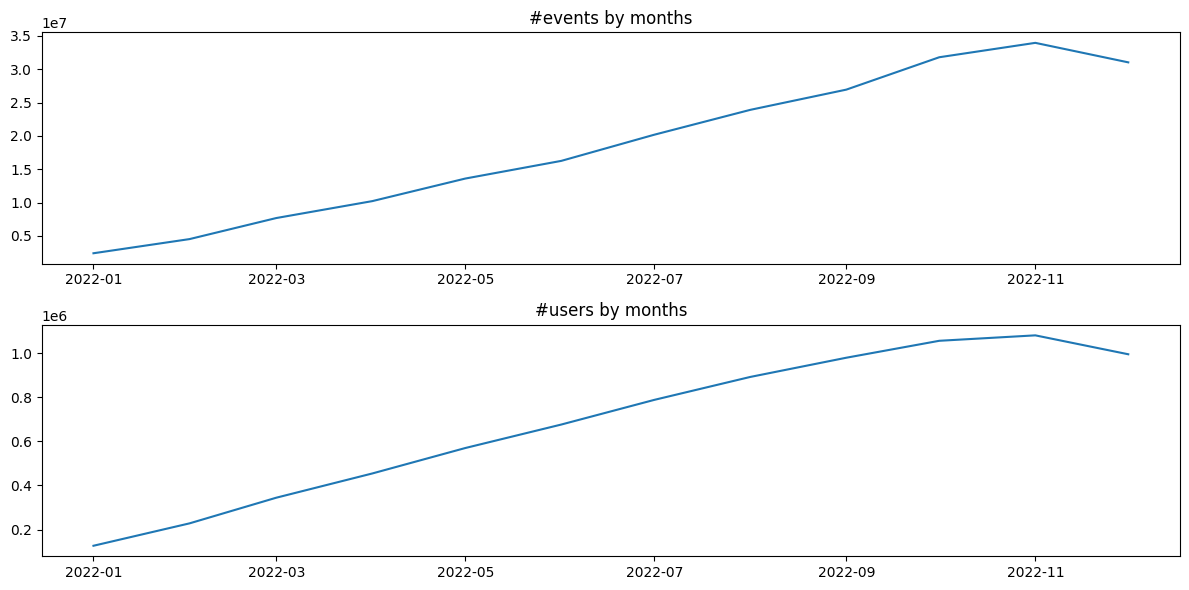

In [16]:
# Визуализируем распределение кол-ва взаимодействий и уникальных пользователей по месяцам

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax = axs[0]
ax.plot(events_by_month["started_at_month"], events_by_month["events"])
ax.set_title("#events by months")

ax = axs[1]
ax.plot(events_by_month["started_at_month"], events_by_month["users"])
ax.set_title("#unique users by months")

fig.tight_layout()

Найдем топ-100 наиболее популярных треков по кол-ву прослушиваний.

In [17]:
pop_items = events \
    .groupby(["item_id"]).agg(plays=("started_at", "count"), users=("user_id", "nunique")) #.reset_index()

# Сортируем по убыванию кол-ва прослушиваний
pop_items = pop_items.sort_values('plays', ascending=False)

# Выбираем первые 100 самых популярных айтемов 
top_k_pop_items = pop_items[:100].reset_index().drop(columns='index')

In [20]:
# Добавляем колонку с именами
top_k_pop_items.merge(items[['item_id', 'name']], how='inner', on='item_id')

,index,item_id,plays,users,name
0,9098,53404,111062,111062,Smells Like Teen Spirit
1,483876,33311009,106921,106921,Believer
2,26665,178529,101924,101924,Numb
3,512157,35505245,99490,99490,I Got Love
4,829320,65851540,86670,86670,Юность
...,...,...,...,...,...
95,146858,3616433,51416,51416,Summertime Sadness
96,64735,628970,50262,50262,I Hate Everything About You
97,397743,27032843,50189,50189,Shut Your Mouth
98,211580,9282507,49932,49932,Родина


Сохраняем в файл `top_popular.parquet` для последующего использования в качестве готовых рекомендаций по умолчанию

In [ ]:
top_k_pop_items.to_parquet('top_popular.parquet')

Определим наиболее популярные жанры. Для этого пройдем по ранее отобранным топ-трекам среди прослушанных и посчитаем,
к каким жанрам они относятся. Наиболее часто встречающиеся жанры будут самыми популярными.

In [ ]:
# Функция для извлечения жанров из треков
def get_genres(items, catalog_names):

    """ 
    Извлекает жанры из треков и считывает, сколько раз встречается каждый жанр.
    """
    cat_genres = catalog_names.query("type == 'genre'")
    
    genres_counter = {}
    
    for k, v in items.iterrows():
        genre_ids = v["genres"] 
        if genre_ids is None or not isinstance(genre_ids, list):
            continue
        
        for genre_id in genre_ids:
            if genre_id == -1:
                continue
            
            genre = cat_genres[cat_genres['id'] == genre_id]['name'].values[0]
            try:
                genres_counter[genre] += 1 
            except KeyError:
                genres_counter[genre] = 1

    genres = pd.Series(genres_counter, name="tracks")
    genres = genres.to_frame()
    genres = genres.reset_index().rename(columns={"index": "name"})
        
    return genres

In [ ]:
genres = get_genres(top_k_pop_items, catalog_names)
genres["score"] = genres["tracks"] / genres["tracks"].sum()
genres.sort_values(by="score", ascending=False).head(10)

In [ ]:
sns.barplot(data=genres.sort_values(by="score", ascending=False).head(10), x='score', y='name').set_title("Top 10 most played genres")

Находим треки, которые никто не прослушал.

In [42]:
# Уникальные id всех треков
all_items_ids = set(items['item_id'])
        
# Уникальные id только прослушанных треков
played_items_ids = set(events['item_id'].unique()) 

# Треки, которых нет в events
not_played_items_ids = list(all_items_ids - played_items_ids)
not_played_items = items[items['track_id'].isin(not_played_items_ids)]
print(not_played_items[['track_id', 'track_name']].to_string())